<a href="https://colab.research.google.com/github/karthikmnkrishna/Loan-default-prediction/blob/Build/Loan_Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOAN CASE STUDY

##DATA & LIBRARIES IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm
import re
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = '/content/drive/My Drive/Masters/loan.csv'
df = pd.read_csv(path)
print(df.shape)

(39717, 111)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## DATA CLEANING AND FORMATING

###Checking if there is any incosistency in column names

In [3]:
df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

The column names have no formating issue

Checking for columns that have only a single value,and hence may not be considered for analysis

In [4]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,90.000000,9.000000,0.0000

In [5]:
df.groupby(['acc_now_delinq','application_type','collections_12_mths_ex_med','initial_list_status','policy_code','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens']).count()['id']

acc_now_delinq  application_type  collections_12_mths_ex_med  initial_list_status  policy_code  pymnt_plan  chargeoff_within_12_mths  delinq_amnt  tax_liens
0               INDIVIDUAL        0.0                         f                    1            n           0.0                       0            0.0          39661
Name: id, dtype: int64

In [6]:
df.drop(['acc_now_delinq','collections_12_mths_ex_med','initial_list_status','policy_code','application_type','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens','url'] ,axis = 1,inplace= True) #REMOVING URL, AS IT SEEMS TO BE A REPITION OF ID COLUMN 

Setting index as id . it seems to be the primary keys as it has all unique values and the description vouches our assumption

In [7]:
df.set_index('id',inplace =True)

###Checking Rows for redundancy/inconsistency

In [8]:
pd.set_option("max_colwidth", None)
df.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay towa

Both the header and footer look fine.There are no extra rows.

###TREATING MISSING VALUES

Lets oserve all the columns with non null and null values and get rid of the columns with only null

In [9]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 1077501 to 87023
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   member_id                       39717 non-null  int64  
 1   loan_amnt                       39717 non-null  int64  
 2   funded_amnt                     39717 non-null  int64  
 3   funded_amnt_inv                 39717 non-null  float64
 4   term                            39717 non-null  object 
 5   int_rate                        39717 non-null  object 
 6   installment                     39717 non-null  float64
 7   grade                           39717 non-null  object 
 8   sub_grade                       39717 non-null  object 
 9   emp_title                       37258 non-null  object 
 10  emp_length                      38642 non-null  object 
 11  home_ownership                  39717 non-null  object 
 12  annual_inc               

COLUMNS WITH ONLY NULL VALUES HAVE BEEN REMOVED.<br>
COLUMNS WITH TOO MANY NULL VALUES HAVE BEEN REMOVED (next_pymnt_d)<br>
ROWS WITH MINIMUM NULL VALUES  HAVE BEEN IGNORED IN SOME CASES<br>

In [10]:
df.drop([ 'annual_inc_joint', 'dti_joint','mths_since_last_major_derog',
 'verification_status_joint','tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75',   'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd','tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit','next_pymnt_d','mths_since_last_record'  ],axis =1,inplace = True)

In [11]:
df = df[~df.title.isna()]
#df = df[~df.pub_rec_bankruptcies.isna()]
df = df[~df.last_pymnt_d.isna()]
df = df[~df.last_credit_pull_d.isna()] 

Cleaning Columns and Rows - after removing the null values <br>CLEANING DESC COLUMN AND FORMATING INTEREST RATE ,ZIP CODE ,Term and other date columns<br>
I'm surious to know if  emp_title or emp_length will give any thing interesting when it is not given.

In [12]:
df.desc.fillna(' ' ,inplace= True)
df.revol_util.fillna(-1 ,inplace= True)#reomve if not useful
df.mths_since_last_delinq.fillna(-1 ,inplace= True)#reomve if not useful
df.emp_title.fillna('Not Given' ,inplace= True)#reomve if not useful
df.emp_length.fillna('Not Given' ,inplace= True)#reomve if not useful
df['desc'] = df.desc.str.replace('<br>' , '')
df['desc'] =df.desc.str.replace('Borrower added on ' , '')
df['desc'] = df.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
df['desc'] =df.desc.str.replace('>' ,'')

In [13]:
df['int_rate'] = df.int_rate.apply(lambda x : float(x.strip('%'))/100 )
df['revol_util'] = df.revol_util.apply(lambda x : float(x.strip('%'))/100 if (x != -1 ) else -1) # -1 so that we can regonize the columns and ignore if necessary

In [14]:
df['zip_code'] = df.zip_code.str.replace('xx' ,'')

In [15]:
df['term']= df.term.str.strip()

In [16]:
df['last_credit_pull_d'] =df.last_credit_pull_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['issue_d'] =df.issue_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['earliest_cr_line'] =df.earliest_cr_line.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['last_pymnt_d'] =df.last_pymnt_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )

In [17]:
df.isna().sum()

member_id                    0
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
term                         0
int_rate                     0
installment                  0
grade                        0
sub_grade                    0
emp_title                    0
emp_length                   0
home_ownership               0
annual_inc                   0
verification_status          0
issue_d                      0
loan_status                  0
desc                         0
purpose                      0
title                        0
zip_code                     0
addr_state                   0
dti                          0
delinq_2yrs                  0
earliest_cr_line             0
inq_last_6mths               0
mths_since_last_delinq       0
open_acc                     0
pub_rec                      0
revol_bal                    0
revol_util                   0
total_acc                    0
out_prncp                    0
out_prnc

###CHECKING FOR OUTLIERS

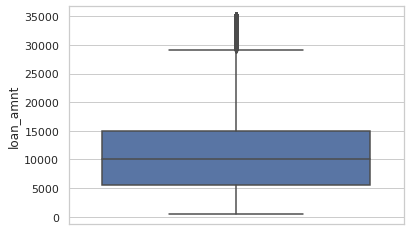

In [18]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt)

In [19]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,3.963300e+04,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,3.963300e+04,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,39633.000000,38937.000000
mean,8.505441e+05,11225.515353,10953.430853,10404.675689,0.120173,324.721103,6.901247e+04,13.318316,0.146267,0.868292,12.044534,9.298287,0.055005,13397.305553,0.486598,22.100724,51.336462,51.097838,12175.618293,11588.250434,9812.127455,2267.820503,1.365904,94.304512,12.299525,2684.297829,0.043198
std,2.657160e+05,7455.337318,7185.759778,7128.607170,0.037247,208.833545,6.384216e+04,6.677228,0.491169,1.069715,21.972346,4.400195,0.237106,15894.461113,0.287642,11.400749,375.562797,374.213029,9036.709284,8938.236885,7059.807662,2608.663170,7.297430,685.618852,148.352482,4450.175844,0.204188
min,7.069900e+04,500.000000,500.000000,0.000000,0.054200,15.690000,4.000000e+03,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,33.730000,0.000000,0.000000,6.220000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.668720e+05,5500.000000,5400.000000,5000.000000,0.092500,167.080000,4.050000e+04,8.190000,0.000000,0.000000,-1.000000,6.000000,0.000000,3711.000000,0.253000,14.000000,0.000000,0.000000,5594.008440,5138.680000,4648.890000,665.160000,0.000000,0.000000,0.000000,219.860000,0.000000
50%,8.508800e+05,10000.000000,9600.000000,8975.000000,0.118300,280.610000,5.900000e+04,13.410000,0.000000,1.000000,-1.000000,9.000000,0.000000,8862.000000,0.492000,20.000000,0.000000,0.000000,9930.508634,9308.160000,8000.000000,1353.290000,0.000000,0.000000,0.000000,548.660000,0.000000
75%,1.047368e+06,15000.000000,15000.000000,14400.000000,0.145900,430.780000,8.240400e+04,18.600000,0.000000,1.000000,21.000000,12.000000,0.000000,17076.000000,0.723000,29.000000,0.000000,0.000000,16553.741870,15815.910000,13703.960000,2838.130000,0.000000,0.000000,0.000000,3307.040000,0.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,0.245900,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,0.999000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


DIGGING DEEPER ON ANNUAL INCOME
<BR>--out_prncp	out_prncp_inv<br>	total_pymnt	total_pymnt_inv	total_rec_prncp	total_rec_int,revol_bal

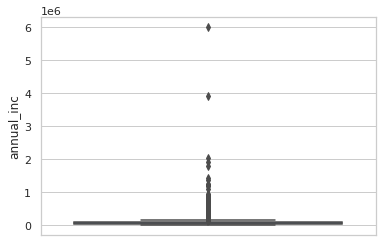

In [20]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)

In [21]:
df.total_pymnt.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1],)

0.000       33.730000
0.001      202.011200
0.010      851.378800
0.025     1288.413729
0.050     1940.316000
0.100     3003.606592
0.250     5594.008440
0.500     9930.508634
0.750    16553.741870
0.975    35502.336006
0.990    42222.797961
1.000    58563.679930
Name: total_pymnt, dtype: float64

In [22]:
df.annual_inc.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99 ,1],)

0.000       4000.000
0.001       8407.584
0.010      14400.000
0.025      19200.000
0.050      24000.000
0.100      30000.000
0.250      40500.000
0.500      59000.000
0.750      82404.000
0.975     175000.000
0.990     235000.000
1.000    6000000.000
Name: annual_inc, dtype: float64

In [23]:
df = df[df.annual_inc.between(df.annual_inc.quantile(0), df.annual_inc.quantile(.99))]

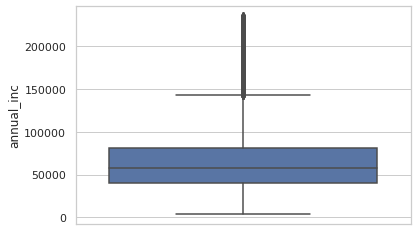

In [24]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)



##UNIVARIATE ANALYSIS


In [119]:
def bar_plot( x,y ,data =df  ,sizerow=10 , sizecolumn =10 ,tabletoggle =True , axistoggle = 'off'):
  ax = data.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True,figsize=(sizerow , sizecolumn),table = tabletoggle )
  plt.axis(axistoggle)
  plt.tight_layout()
  plt.show()


###Amount Distribution

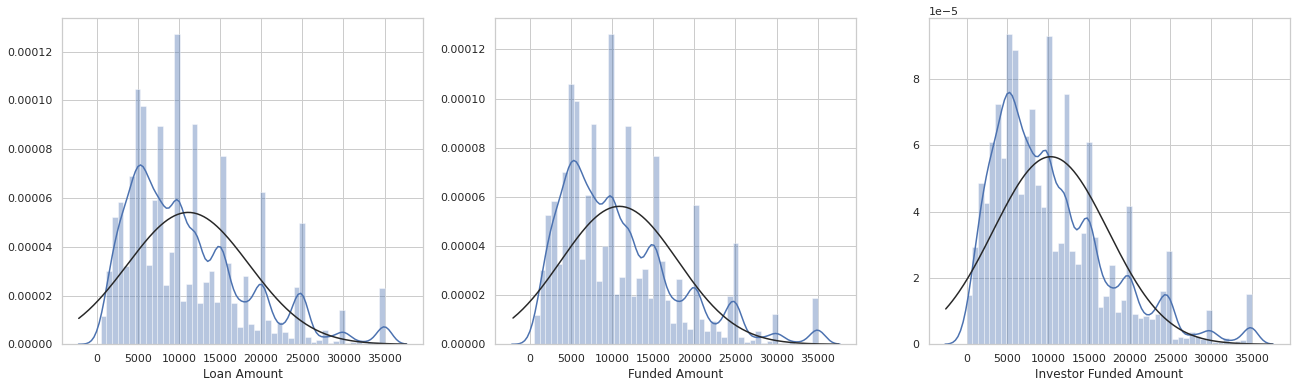

In [25]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,3,1)
sns.distplot(df.loan_amnt,fit = norm)
plt.xlabel('Loan Amount')
plt.subplot(1,3,2)
sns.distplot(df.funded_amnt,fit = norm )
plt.xlabel('Funded Amount')
plt.subplot(1,3,3)
sns.distplot(df.funded_amnt_inv,fit = norm)
plt.xlabel('Investor Funded Amount')
plt.show()

###Loan Terms

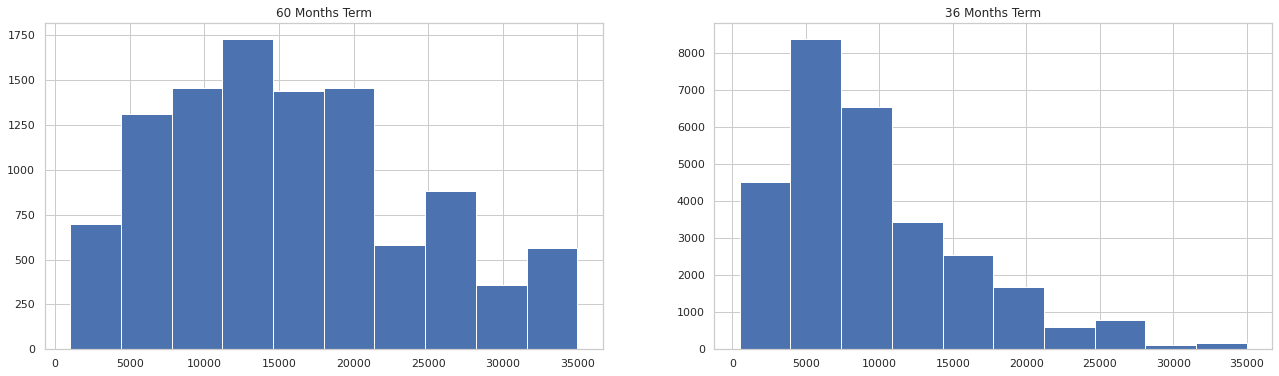

In [26]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,2,1)
df[df.term == '60 months'].loan_amnt.hist()
plt.title('60 Months Term')
plt.subplot(1,2,2)
df[df.term == '36 months'].loan_amnt.hist()
plt.title('36 Months Term')
plt.show()

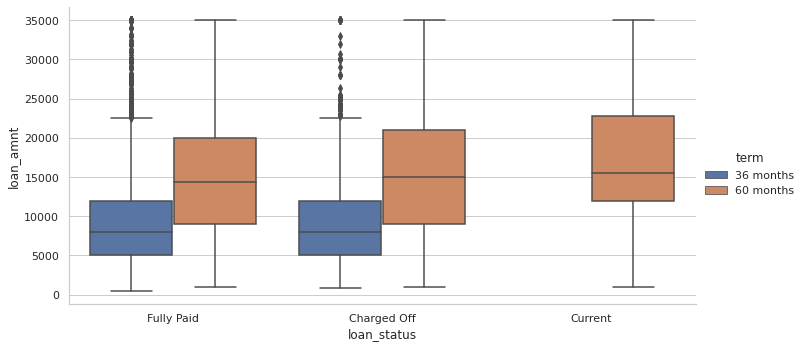

In [27]:
sns.catplot(x="loan_status", y="loan_amnt", hue="term", kind="box", data=df,height=5, aspect=2)

###Loan distribution by issue Year

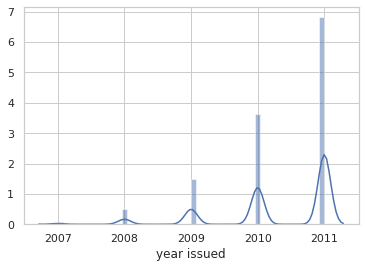

In [28]:
df['issue_year']=pd.DatetimeIndex(df.issue_d).year
sns.distplot(df.issue_year , hist=True, hist_kws={"color": "b", "alpha":.5, "rwidth":41 , "histtype" : "stepfilled"})
plt.xlabel('year issued')
plt.show()

###Impact of Verification status

In [29]:
pd.crosstab(index=  [df.verification_status],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
verification_status,,,
Not Verified,0.124665,0.013521,0.861814
Source Verified,0.142988,0.031075,0.825937
Verified,0.159594,0.047037,0.793369


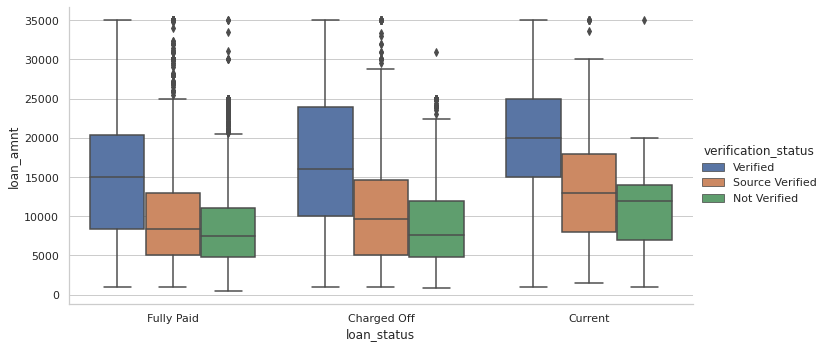

In [30]:
sns.catplot(x="loan_status", y="loan_amnt", hue="verification_status", kind="box", data=df,height=5, aspect=2)

###loan amount 

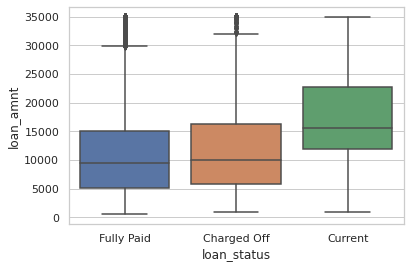

In [31]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt , x= df.loan_status)

Loan amount doesnt seem to have major impact on status , although loan amount is more varied in case of charged off loans.

###Annual Income<br>

LETS OBSERVE IMPACT OF ANNUAL INCOME ON LOAN STATUS

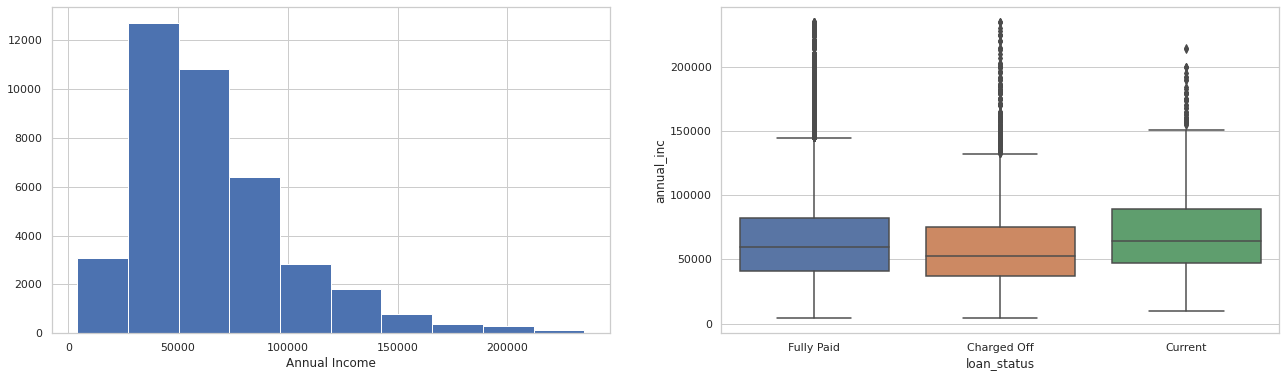

In [32]:
plt.subplots(figsize=(22,6)) 
plt.subplot(1,2,1)
df.annual_inc.hist()
plt.xlabel('Annual Income')
plt.subplot(1,2,2)
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc , x= df.loan_status)
plt.show()

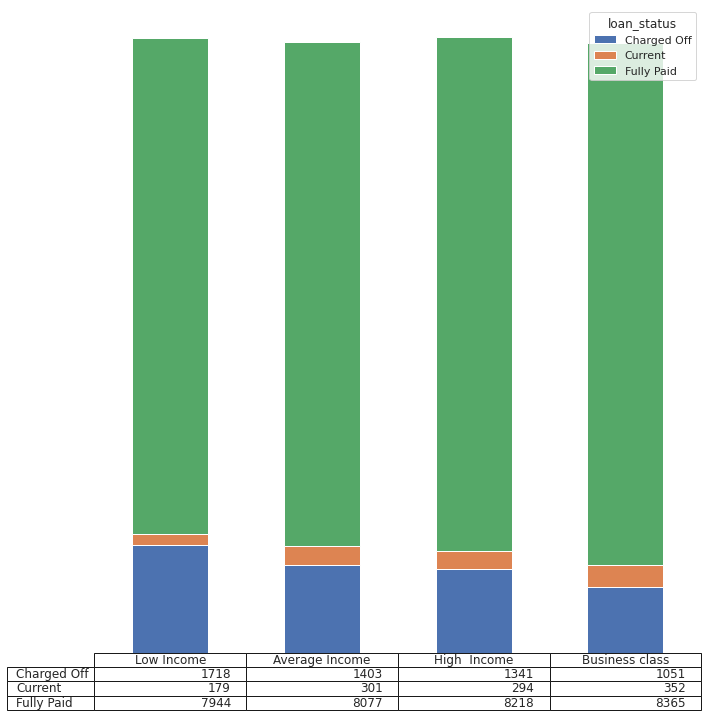

In [106]:
df['annual_inc_bin'] = pd.qcut(df.annual_inc, 4, labels=['Low Income','Average Income','High  Income' ,'Business class'],duplicates = 'drop')
bar_plot(x='annual_inc_bin',y='loan_status' )

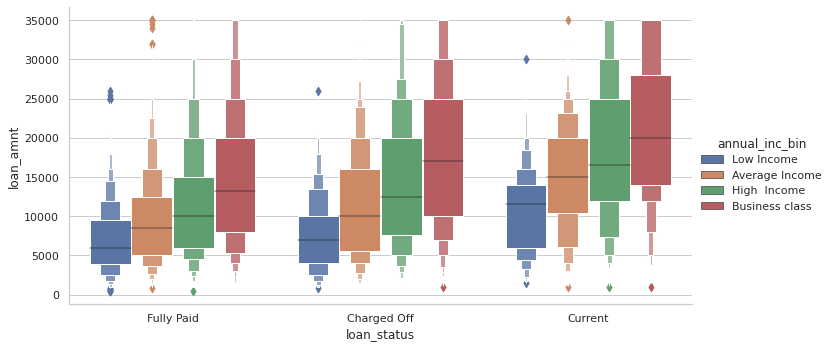

In [34]:
sns.catplot(x="loan_status", y="loan_amnt", hue="annual_inc_bin", kind="boxen", data=df,height=5, aspect=2)

the annual income seems to be on the lower side in case of charged off loans

###CHECKING THE IMPACT OF dti on LOAN STATUS

In [35]:
df.dti.describe()

count    39243.000000
mean        13.379170
std          6.661404
min          0.000000
25%          8.280000
50%         13.480000
75%         18.640000
max         29.990000
Name: dti, dtype: float64

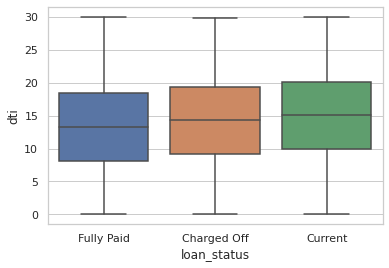

In [36]:
sns.set(style="whitegrid")
sns.boxplot(y=df.dti , x= df.loan_status) 

###DTI Score analysis

In [37]:
df.dti.describe()

count    39243.000000
mean        13.379170
std          6.661404
min          0.000000
25%          8.280000
50%         13.480000
75%         18.640000
max         29.990000
Name: dti, dtype: float64

In [38]:
df.dti.quantile([0,.2,.4,.6, .8,1])

0.0     0.000
0.2     7.080
0.4    11.460
0.6    15.420
0.8    19.796
1.0    29.990
Name: dti, dtype: float64

In [39]:
df['dti_bin'] = pd.qcut(df.dti, 4, labels=False,duplicates = 'drop')
pd.crosstab([df.dti_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
dti_bin,,,
0,0.120065,0.020452,0.859483
1,0.132980,0.028656,0.838364
2,0.149251,0.028749,0.822000
3,0.159694,0.036939,0.803367


As Dti increases , there is a slight increase in loan chared off

###CHECKING THE IMPACT OF LAST 6 MONTHS ENQUIRY on LOAN STATUS

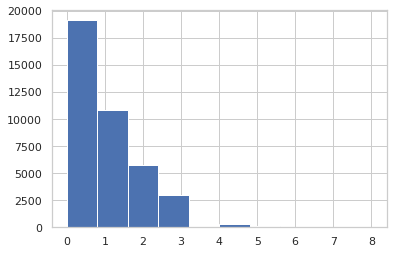

In [40]:
df.inq_last_6mths.hist()

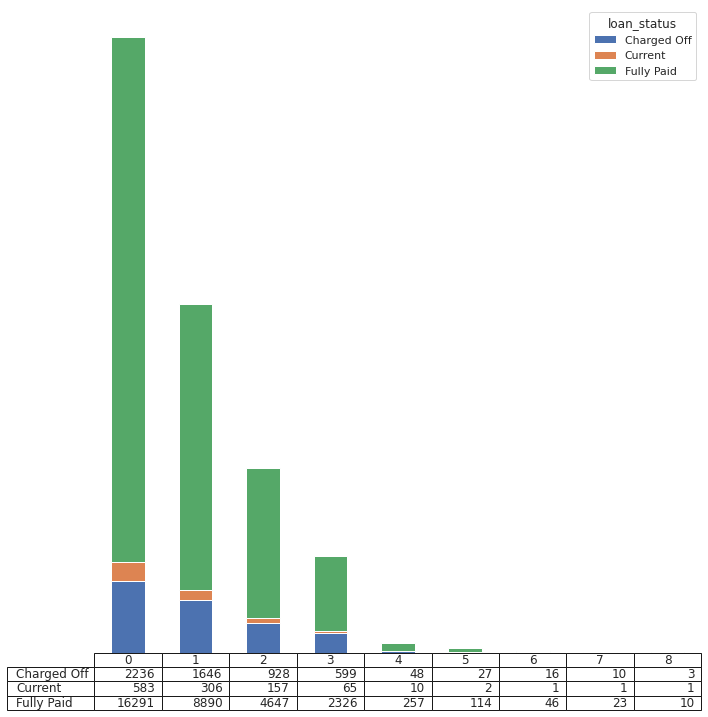

In [131]:
bar_plot('inq_last_6mths' , 'loan_status')

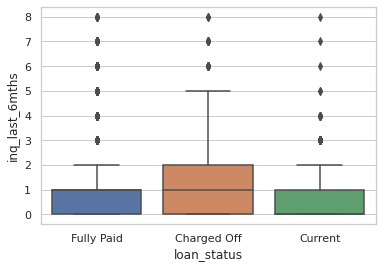

In [41]:
sns.set(style="whitegrid")
sns.boxplot(y=df.inq_last_6mths , x= df.loan_status) 

In [134]:
pd.crosstab(df.inq_last_6mths ,df.loan_status ,values= df.loan_amnt,aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
inq_last_6mths,,,
0,0.117007,0.030508,0.852486
1,0.151817,0.028224,0.819959
2,0.161898,0.027390,0.810712
3,0.200334,0.021739,0.777926
4,0.152381,0.031746,0.815873
5,0.188811,0.013986,0.797203
6,0.253968,0.015873,0.730159
7,0.294118,0.029412,0.676471
8,0.214286,0.071429,0.714286


chances of loan being charged off seems to increase with increase in enquiries

###checking impact of interest rate

In [42]:
df.int_rate.describe()

count    39243.000000
mean         0.120028
std          0.037173
min          0.054200
25%          0.092500
50%          0.118300
75%          0.145400
max          0.245900
Name: int_rate, dtype: float64

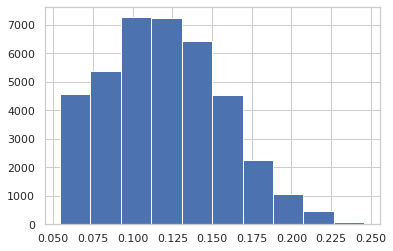

In [43]:
df.int_rate.hist()

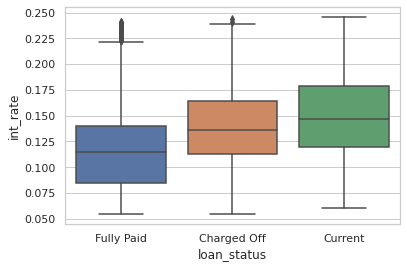

In [44]:
sns.set(style="whitegrid")
sns.boxplot(y=df.int_rate , x= df.loan_status) 

Increase in intrest rate  increases the chances of loan being charged off

###checking impact of utilization rate

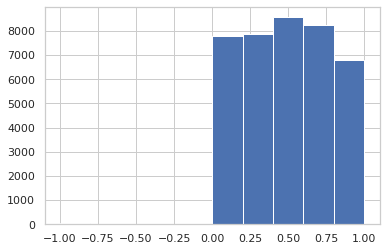

In [45]:
df.revol_util.hist()

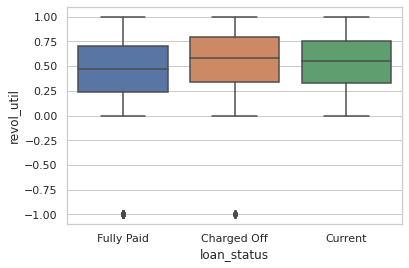

In [46]:
sns.set(style="whitegrid")
sns.boxplot(y=df.revol_util , x= df.loan_status) 

Increase in utilization of revolving line  increases the chances of loan being charged off

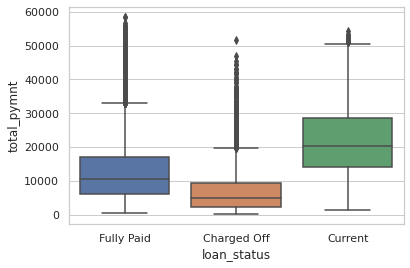

In [47]:
sns.set(style="whitegrid")
sns.boxplot(y=df.total_pymnt , x= df.loan_status) 

###Grade

In [48]:
#df.groupby(['grade','loan_status'])['loan_amnt'].describe()
pd.crosstab(index = [df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059441,0.003996,0.936563
B,0.117410,0.028891,0.853700
C,0.164790,0.032783,0.802427
D,0.210325,0.041300,0.748375
E,0.250270,0.063378,0.686352
F,0.304008,0.069404,0.626588
G,0.319079,0.055921,0.625000


###Purpose

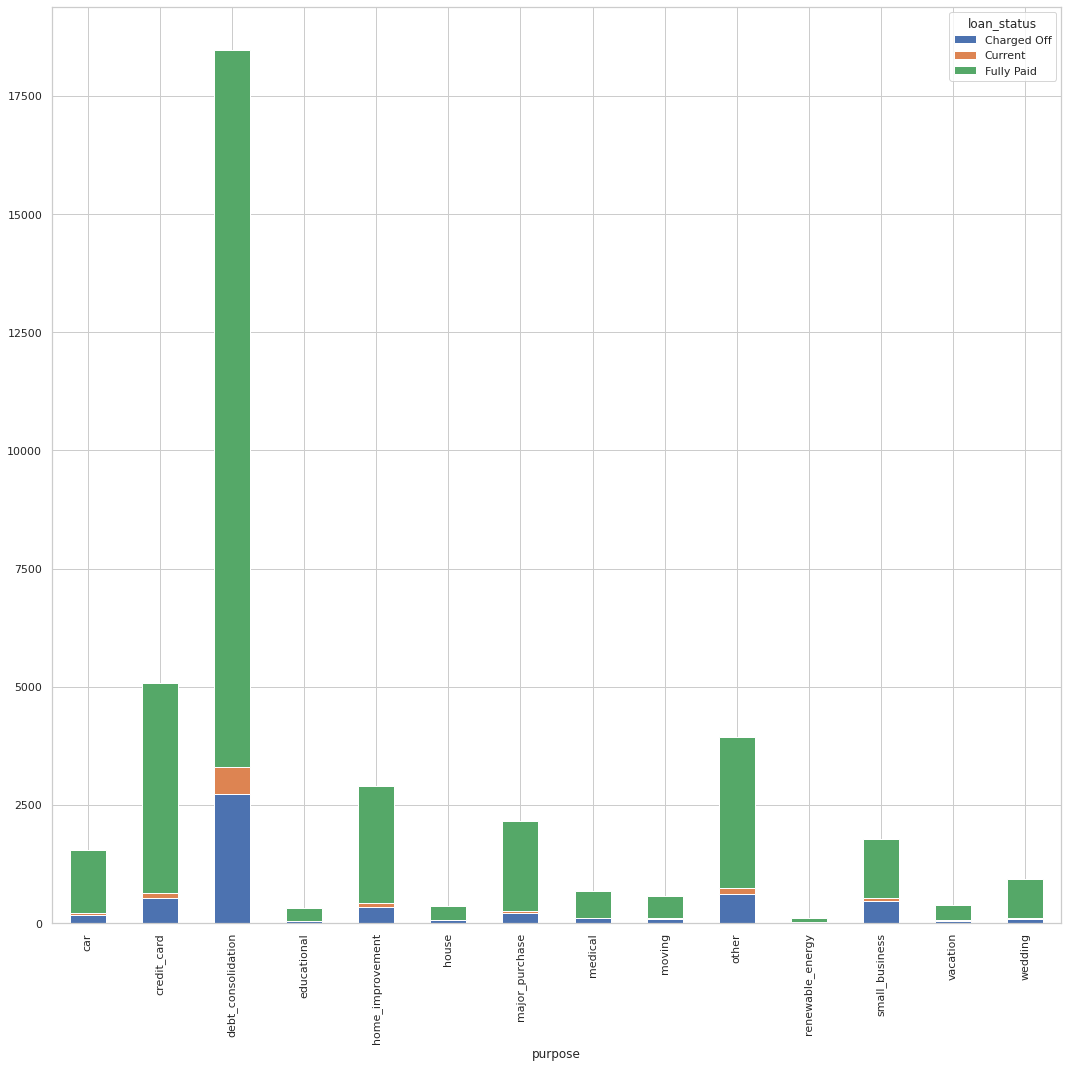

In [122]:
bar_plot('purpose', 'loan_status',tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [49]:
pd.crosstab([df.purpose],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103761,0.032425,0.863813
credit_card,0.105170,0.020051,0.874779
debt_consolidation,0.147460,0.031409,0.821131
educational,0.166144,0.000000,0.833856
home_improvement,0.115877,0.033552,0.850571
house,0.151351,0.037838,0.810811
major_purchase,0.099491,0.017122,0.883387
medical,0.153285,0.017518,0.829197
moving,0.157712,0.012132,0.830156


###Region Analysis

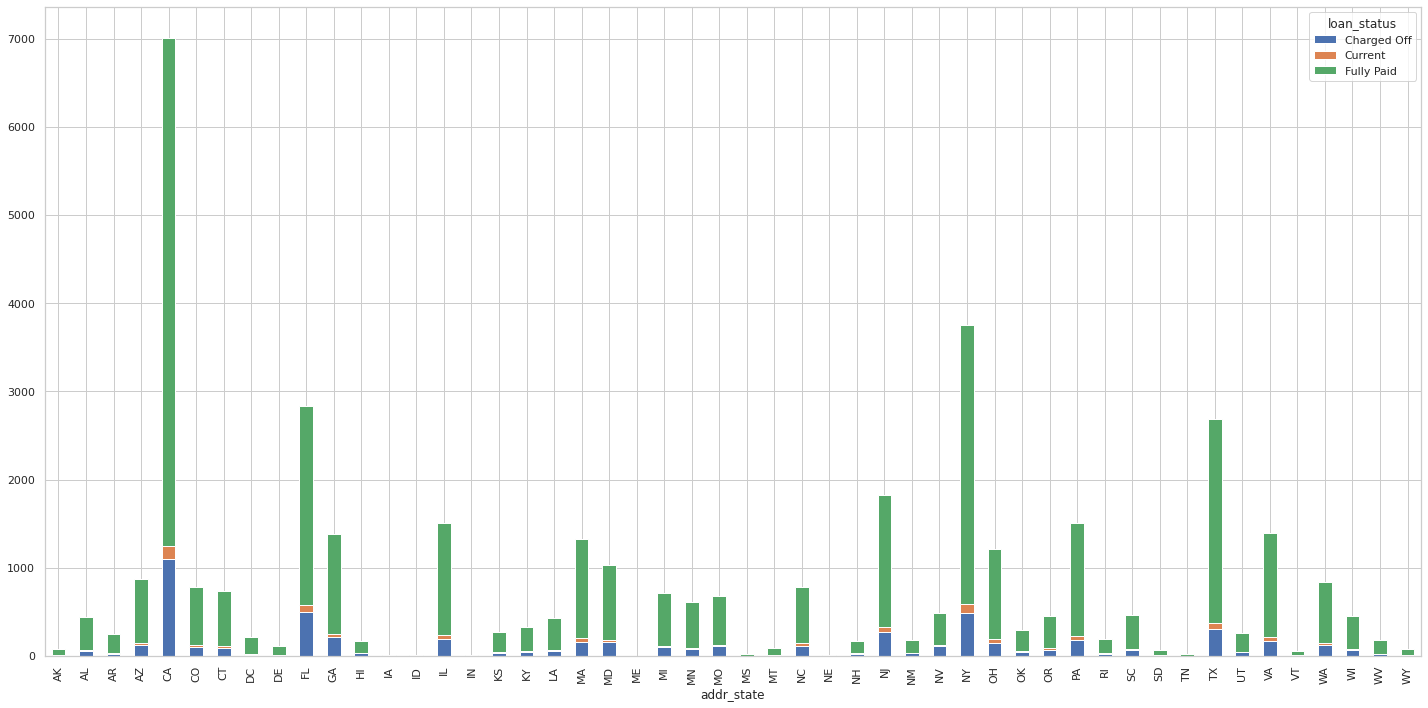

In [139]:
bar_plot('addr_state', 'loan_status' , axistoggle= 'on',tabletoggle= False,sizerow= 20)

In [50]:
pd.crosstab([df.addr_state],df.loan_status,values=df.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
addr_state,,,
AK,0.177215,0.025316,0.797468
AL,0.116331,0.038031,0.845638
AR,0.110204,0.040816,0.848980
AZ,0.138408,0.034602,0.826990
CA,0.156468,0.021252,0.822279
CO,0.123077,0.033333,0.843590
CT,0.126531,0.032653,0.840816
DC,0.070093,0.014019,0.915888
DE,0.097345,0.008850,0.893805


In [147]:
#map states to regions
states = {
     'AK' :  'West' ,  'AL' :  'South' ,  'AR' :  'South' ,  'AZ' :  'West' ,  'CA' :  'West' ,  'CO' :  'West' ,  'CT' :  'Northeast' ,
       'DC' :  'South' ,  'DE' :  'South' ,  'FL' :  'South' ,  'GA' :  'South' ,  'HI' :  'West' ,  'IA' :  'Midwest' ,  'ID' :  'West' , 
        'IL' :  'Midwest' ,  'IN' :  'Midwest' ,  'KS' :  'Midwest' ,  'KY' :  'South' ,  'LA' :  'South' ,  'MA' :  'Northeast' ,  'MD' :  'South' , 
         'ME' :  'Northeast' ,  'MI' :  'Midwest' ,  'MN' :  'Midwest' ,  'MO' :  'Midwest' ,  'MS' :  'South' ,  'MT' :  'West' ,  'NC' :  'South' ,
          'ND' :  'Midwest' ,  'NE' :  'Midwest' ,  'NH' :  'Northeast' ,  'NJ' :  'Northeast' ,  'NM' :  'West' ,  'NV' :  'West' ,  'NY' :  'Northeast' , 
          'OH' :  'Midwest' ,  'OK' :  'South' ,  'OR' :  'West' ,  'PA' :  'Northeast' ,  'RI' :  'Northeast' ,  'SC' :  'South' ,  'SD' :  'Midwest' , 
          'TN' :  'South' ,  'TX' :  'South' ,  'UT' :  'West' ,  'VA' :  'South' ,  'VT' :  'Northeast' ,  'WA' :  'West' ,  'WI' :  'Midwest' , 
          'WV' :  'South' ,  'WY' :  'West' 
}
df['Region']= df['addr_state'].map(states)


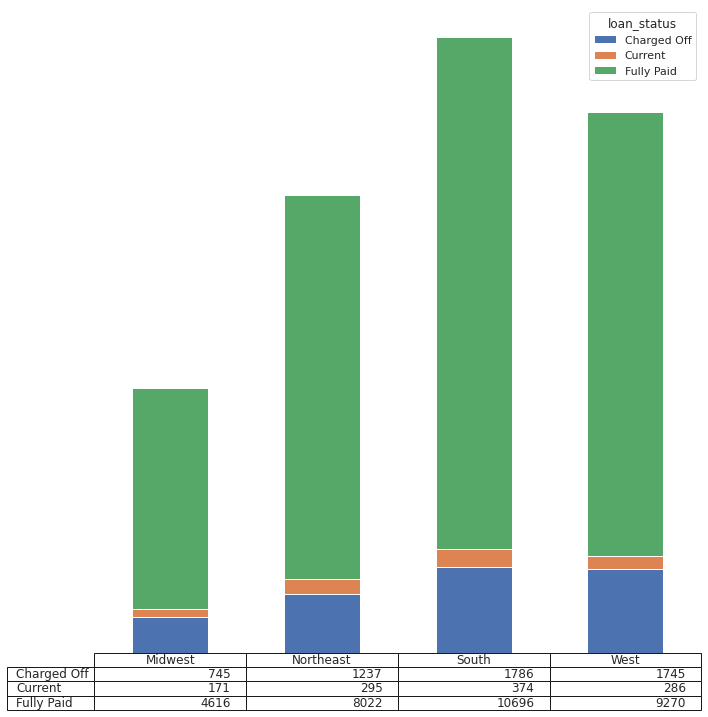

In [142]:
bar_plot('Region' , 'loan_status')


In [143]:
pd.crosstab([df.Region],df.loan_status,values=df.loan_amnt,aggfunc='count' ,normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
Region,,,
Midwest,0.134671,0.030911,0.834418
Northeast,0.129475,0.030877,0.839648
South,0.138923,0.029091,0.831985
West,0.154411,0.025307,0.820281


In [51]:
pd.crosstab(index = [df.term] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
term,,,
36 months,0.109477,0.000000,0.890523
60 months,0.225594,0.107453,0.666953


##BIVARIATE ANALYSIS

###Correlation

In [52]:
rs = np.random.RandomState(0)
cor = df[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','out_prncp','out_prncp_inv','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.023085,-0.109358,0.036534,0.413736,0.216687,0.416101,0.260836,0.057594,0.057375,-0.021755,-0.018207,0.423509,0.046024,0.377027,0.394755,0.380058,0.282550,0.014332,0.396825
collection_recovery_fee,0.023085,1.000000,0.012419,0.012387,0.075266,-0.041514,0.073078,0.005942,-0.011330,-0.011317,-0.005275,-0.004990,0.023851,0.026618,0.009876,0.024863,0.015652,0.033874,0.091432,-0.058862
dti,-0.109358,0.012419,1.000000,0.003923,0.064025,0.010411,0.075948,0.292769,0.037648,0.037571,-0.005447,0.004706,0.243943,0.276989,0.236364,0.073589,0.080206,0.113193,-0.011445,0.049876
inq_last_6mths,0.036534,0.012387,0.003923,1.000000,0.006372,0.027680,0.005870,0.091667,-0.010864,-0.010530,0.025829,0.016873,-0.023891,-0.066643,0.109940,-0.012432,-0.022131,0.021183,0.031318,-0.025608
installment,0.413736,0.075266,0.064025,0.006372,1.000000,0.400146,0.929591,0.168904,0.125401,0.125243,-0.045058,-0.031590,0.306342,0.100596,0.224486,0.856949,0.816925,0.634862,0.058113,0.850199
last_pymnt_amnt,0.216687,-0.041514,0.010411,0.027680,0.400146,1.000000,0.447147,0.077550,-0.066578,-0.066508,-0.031024,-0.021420,0.115305,-0.014656,0.161153,0.473757,0.461517,0.189765,-0.060683,0.542859
loan_amnt,0.416101,0.073078,0.075948,0.005870,0.929591,0.447147,1.000000,0.173744,0.194048,0.193721,-0.049819,-0.034989,0.312630,0.071386,0.250997,0.886717,0.853969,0.730459,0.046024,0.851290
open_acc,0.260836,0.005942,0.292769,0.091667,0.168904,0.077550,0.173744,1.000000,0.027647,0.027462,0.001383,0.007469,0.288624,-0.083008,0.685952,0.158952,0.149307,0.120649,-0.018042,0.157250
out_prncp,0.057594,-0.011330,0.037648,-0.010864,0.125401,-0.066578,0.194048,0.027647,1.000000,0.999823,-0.012414,-0.009795,0.058199,0.038512,0.031085,0.240282,0.247423,0.384210,-0.004269,0.167507
out_prncp_inv,0.057375,-0.011317,0.037571,-0.010530,0.125243,-0.066508,0.193721,0.027462,0.999823,1.000000,-0.012653,-0.010090,0.057977,0.038675,0.030894,0.239951,0.247407,0.383862,-0.004379,0.167211


###Check Grade/Subgrade/Term

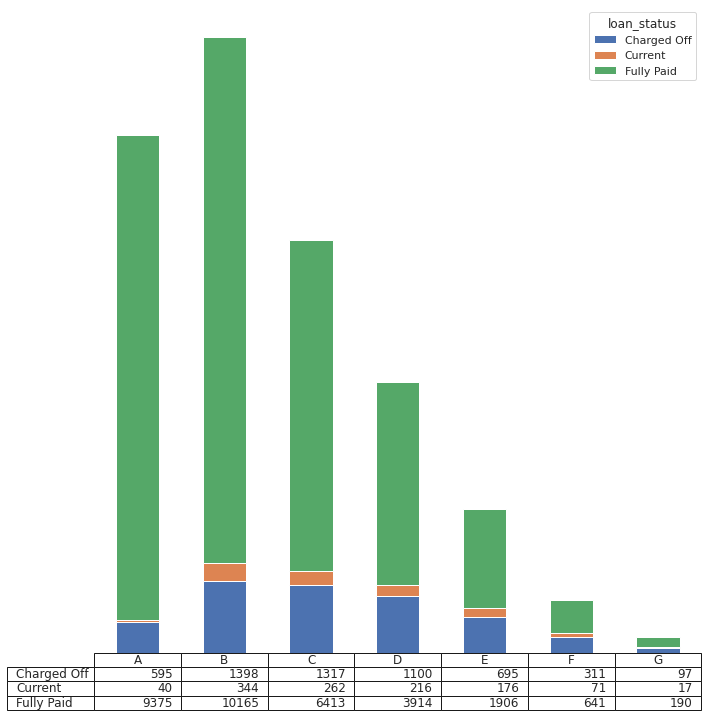

In [112]:
bar_plot('grade','loan_status')

In [86]:
pd.crosstab(index = [df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059441,0.003996,0.936563
B,0.117410,0.028891,0.853700
C,0.164790,0.032783,0.802427
D,0.210325,0.041300,0.748375
E,0.250270,0.063378,0.686352
F,0.304008,0.069404,0.626588
G,0.319079,0.055921,0.625000


In [54]:
pd.crosstab(index = [df.term ,df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status      Charged Off   Current  Fully Paid
term      grade                                   
36 months A         0.058271  0.000000    0.941729
          B         0.104203  0.000000    0.895797
          C         0.144897  0.000000    0.855103
          D         0.178414  0.000000    0.821586
          E         0.198582  0.000000    0.801418
          F         0.254902  0.000000    0.745098
          G         0.363636  0.000000    0.636364
60 months A         0.085253  0.092166    0.822581
          B         0.162991  0.128598    0.708411
          C         0.213454  0.112980    0.673566
          D         0.259747  0.105263    0.634990
          E         0.272916  0.091144    0.635940
          F         0.316239  0.086691    0.597070
          G         0.309237  0.068273    0.622490

In [55]:
pd.crosstab(index = [df.grade,df.sub_grade,df.term ] , columns = [df.loan_status] , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status                Charged Off   Current  Fully Paid
grade sub_grade term                                        
A     A1        36 months     0.026525  0.000000    0.973475
      A2        36 months     0.048518  0.000000    0.951482
                60 months     0.071429  0.000000    0.928571
      A3        36 months     0.057517  0.000000    0.942483
                60 months     0.024390  0.000000    0.975610
...                                ...       ...         ...
G     G3        60 months     0.348837  0.069767    0.581395
      G4        36 months     0.333333  0.000000    0.666667
                60 months     0.204545  0.045455    0.750000
      G5        36 months     0.600000  0.000000    0.400000
                60 months     0.210526  0.052632    0.736842

[69 rows x 3 columns]

###Home Ownership ,Verification Status and Term

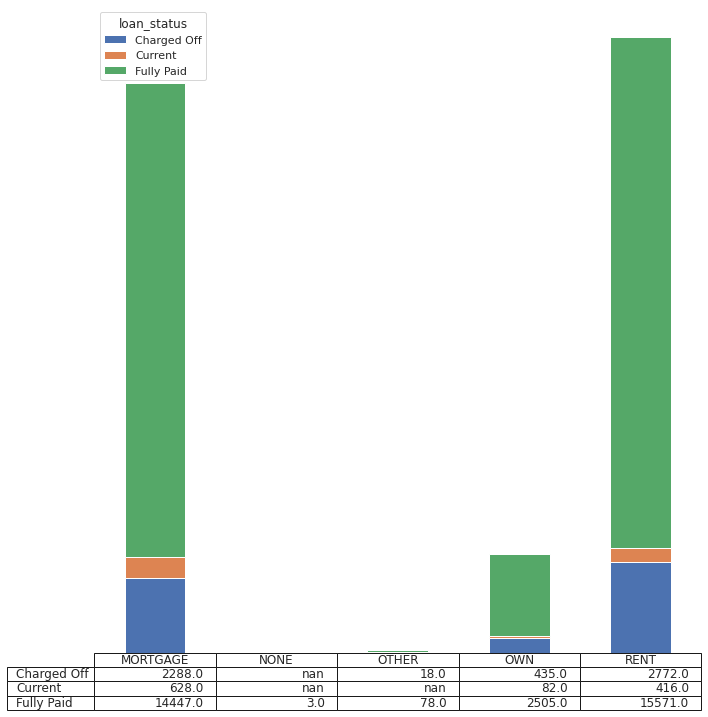

In [111]:
bar_plot('home_ownership','loan_status')

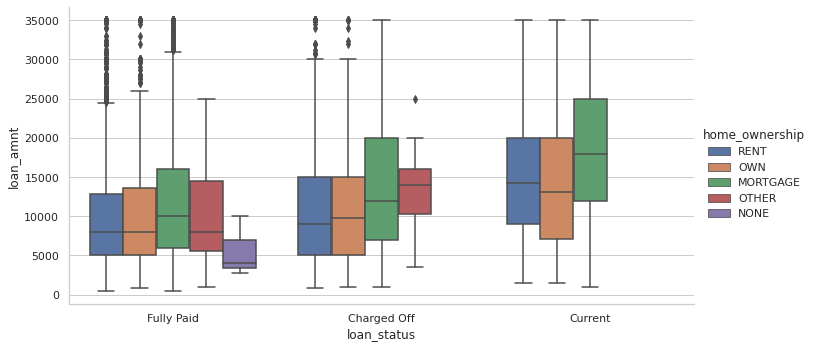

In [56]:
sns.catplot(x="loan_status", y="loan_amnt", hue="home_ownership", kind="box", data=df,height=5, aspect=2)

In [84]:
pd.crosstab(index=  [df.home_ownership],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
home_ownership,,,
MORTGAGE,0.131774,0.036169,0.832057
NONE,0.000000,0.000000,1.000000
OTHER,0.187500,0.000000,0.812500
OWN,0.143944,0.027134,0.828921
RENT,0.147769,0.022176,0.830055


In [58]:
pd.crosstab(index=  [df.term,df.home_ownership],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status               Charged Off   Current  Fully Paid
term      home_ownership                                   
36 months MORTGAGE           0.098177  0.000000    0.901823
          NONE               0.000000  0.000000    1.000000
          OTHER              0.178947  0.000000    0.821053
          OWN                0.108132  0.000000    0.891868
          RENT               0.118389  0.000000    0.881611
60 months MORTGAGE           0.202945  0.112787    0.684267
          OTHER              1.000000  0.000000    0.000000
          OWN                0.253012  0.109772    0.637216
          RENT               0.250781  0.099928    0.649291

In [59]:
pd.crosstab(index= [df.verification_status,df.home_ownership,df.term ] ,columns= [df.loan_status] , values= df.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                                   Charged Off   Current  Fully Paid
verification_status home_ownership term                                        
Not Verified        MORTGAGE       36 months     0.101837  0.000000    0.898163
                                   60 months     0.194712  0.092949    0.712340
                    NONE           36 months     0.000000  0.000000    1.000000
                    OTHER          36 months     0.176471  0.000000    0.823529
                                   60 months     1.000000  0.000000    0.000000
                    OWN            36 months     0.112588  0.000000    0.887412
                                   60 months     0.207254  0.119171    0.673575
                    RENT           36 months     0.118912  0.000000    0.881088
                                   60 months     0.210748  0.092729    0.696523
Source Verified     MORTGAGE       36 months     0.080879  0.000000    0.919121
                                   60 months     0.204730  0.111604    0.683666
                    OTHER          36 months     0.100000  0.000000    0.900000
                    OWN            36 months     0.091954  0.000000    0.908046
                                   60 months     0.278481  0.118143    0.603376
                    RENT           36 months     0.117988  0.000000    0.882012
                                   60 months     0.262129  0.091962    0.645909
Verified            MORTGAGE       36 months     0.104727  0.000000    0.895273
                                   60 months     0.205595  0.121672    0.672733
                    OTHER          36 months     0.205882  0.000000    0.794118
                    OWN            36 months     0.113924  0.000000    0.886076
                                   60 months     0.261830  0.097792    0.640379
                    RENT           36 months     0.117715  0.000000    0.882285
                                   60 months     0.262957  0.109656    0.627387

###Purpose/Term

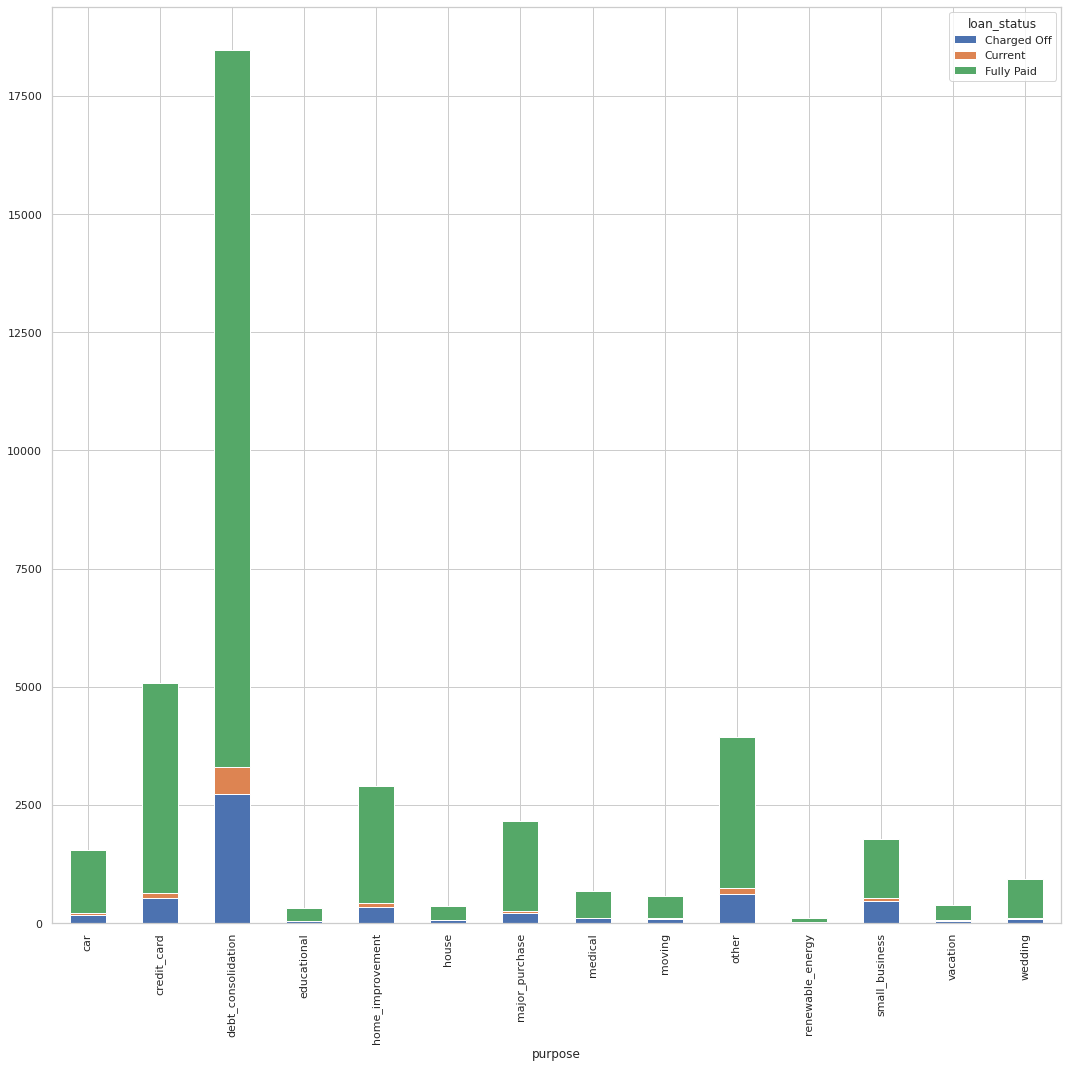

In [121]:
bar_plot('purpose', 'loan_status',tabletoggle= False,sizecolumn= 15 , sizerow= 15,axistoggle= 'on')

In [60]:
pd.crosstab([df.purpose],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.103761,0.032425,0.863813
credit_card,0.105170,0.020051,0.874779
debt_consolidation,0.147460,0.031409,0.821131
educational,0.166144,0.000000,0.833856
home_improvement,0.115877,0.033552,0.850571
house,0.151351,0.037838,0.810811
major_purchase,0.099491,0.017122,0.883387
medical,0.153285,0.017518,0.829197
moving,0.157712,0.012132,0.830156


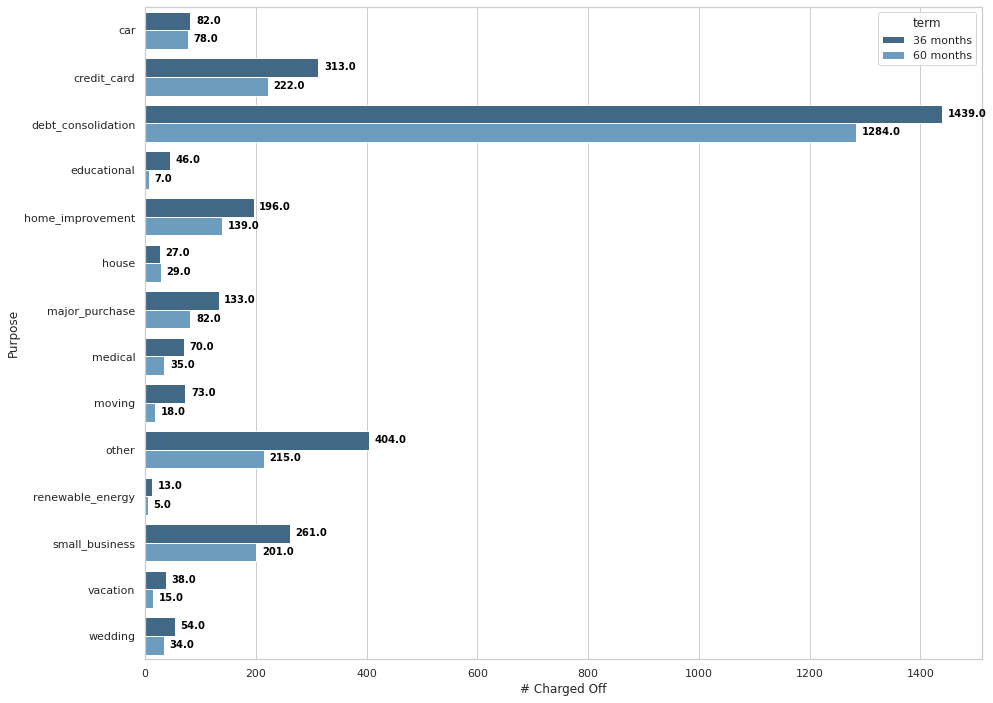

In [61]:
df1= pd.crosstab([df.purpose ,df.term ],[df.loan_status],values=df.loan_amnt,aggfunc='count').reset_index().fillna(0)
fig, ax = plt.subplots(figsize=(15,12))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Charged Off' ,y ='purpose',data =  df1 ,hue = 
            'term' ,palette= 'Blues_d').set(
                xlabel ='# Charged Off' , ylabel= 'Purpose')
#to get values next to bar plots(THIS WILL THROW WARNINGS , WHICH IS IGNORED)
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.25, str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='black')
plt.show()


In [62]:
pd.crosstab([df.purpose ,df.term ],[df.loan_status],values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status                   Charged Off   Current  Fully Paid
purpose            term                                        
car                36 months     0.083588  0.000000    0.916412
                   60 months     0.139037  0.089127    0.771836
credit_card        36 months     0.077170  0.000000    0.922830
                   60 months     0.215325  0.098933    0.685742
debt_consolidation 36 months     0.110522  0.000000    0.889478
                   60 months     0.235769  0.106500    0.657730
educational        36 months     0.151815  0.000000    0.848185
                   60 months     0.437500  0.000000    0.562500
home_improvement   36 months     0.097367  0.000000    0.902633
                   60 months     0.158314  0.110478    0.731207
house              36 months     0.105882  0.000000    0.894118
                   60 months     0.252174  0.121739    0.626087
major_purchase     36 months     0.078006  0.000000    0.921994
                   60 months     0.179825  0.081140    0.739035
medical            36 months     0.134357  0.000000    0.865643
                   60 months     0.213415  0.073171    0.713415
moving             36 months     0.152401  0.000000    0.847599
                   60 months     0.183673  0.071429    0.744898
other              36 months     0.130071  0.000000    0.869929
                   60 months     0.255952  0.150000    0.594048
renewable_energy   36 months     0.173333  0.000000    0.826667
                   60 months     0.200000  0.040000    0.760000
small_business     36 months     0.215524  0.000000    0.784476
                   60 months     0.348958  0.128472    0.522569
vacation           36 months     0.118380  0.000000    0.881620
                   60 months     0.250000  0.100000    0.650000
wedding            36 months     0.075209  0.000000    0.924791
                   60 months     0.159624  0.093897    0.746479

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea

###DESC 

Lets check if length of description has any effect on the outcome

In [63]:
df['desc_len'] = df.desc.apply(lambda c :len(c))

In [64]:
df.desc_len.describe()

count    39243.000000
mean       265.986877
std        408.610238
min          1.000000
25%          1.000000
50%        118.000000
75%        357.000000
max       3966.000000
Name: desc_len, dtype: float64

In [65]:
df.desc_len.quantile([.1, .25, .5, .75,.80,.90,.95]) 

0.10       1.0
0.25       1.0
0.50     118.0
0.75     357.0
0.80     439.0
0.90     711.0
0.95    1030.0
Name: desc_len, dtype: float64

In [66]:
df['desc_len_bin'] = pd.qcut(df.desc_len, 200, labels=False,duplicates = 'drop')

In [67]:

pd.crosstab([df.desc_len_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
desc_len_bin,,,
0,0.137556,0.031557,0.830887
1,0.121212,0.043290,0.835498
2,0.108280,0.038217,0.853503
3,0.116162,0.050505,0.833333
4,0.184211,0.048246,0.767544
...,...,...,...
129,0.147208,0.025381,0.827411
130,0.183673,0.010204,0.806122
131,0.153061,0.020408,0.826531


###CHECK ON FICO SCORE 

In [68]:
df['fico']=df.desc.apply(lambda x : 1 if re.search('fico' ,x ) else 0 )

In [69]:
#df[df.fico == 1]
pd.crosstab([df.fico  ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
fico,,,
0,0.14034,0.028711,0.830949
1,0.37500,0.000000,0.625000


In [70]:
dff =df[df.fico == 1]
pd.crosstab([dff.purpose  ],dff.loan_status,values=dff.loan_amnt,aggfunc='count',
           normalize='columns')

loan_status,Charged Off,Fully Paid
purpose,,
car,0.111111,0.000000
credit_card,0.111111,0.066667
debt_consolidation,0.666667,0.533333
house,0.000000,0.066667
major_purchase,0.000000,0.066667
other,0.111111,0.133333
small_business,0.000000,0.133333


Higher chances of loan getting charged off if fico is mentioned on desc<br>
The cases where charged off is higher are mostly(~88%) debt consolidation/other when Fico is mentioned.

###Interest Rates/Employee length/Grade

Binning Interest rates into quartiles

In [71]:
df.int_rate.quantile([0.25,0.5,0.75,1])

0.25    0.0925
0.50    0.1183
0.75    0.1454
1.00    0.2459
Name: int_rate, dtype: float64

In [72]:
df['interest_bin'] = pd.qcut(df.int_rate, 4, labels=['<0.09' , '<.12' , '<.15' , '<.25'],duplicates = 'drop')

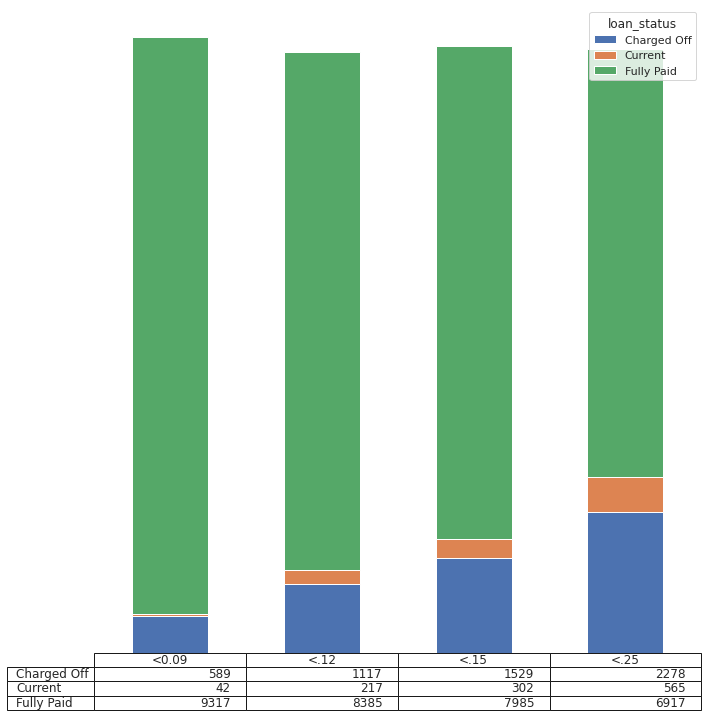

In [124]:
bar_plot('interest_bin' ,'loan_status')

In [73]:
pd.crosstab([df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status,Charged Off,Current,Fully Paid
interest_bin,,,
<0.09,0.059208,0.004222,0.936570
<.12,0.114930,0.022327,0.862743
<.15,0.155766,0.030766,0.813468
<.25,0.233402,0.057889,0.708709


As the interest rates grow higher the chances of charging off  the loan increases.

In [74]:
pd.crosstab([df.emp_length , df.interest_bin ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status              Charged Off   Current  Fully Paid
emp_length interest_bin                                   
1 year     <0.09            0.063114  0.007013    0.929874
           <.12             0.137515  0.006031    0.856454
           <.15             0.130531  0.019912    0.849558
           <.25             0.219577  0.054233    0.726190
10+ years  <0.09            0.061626  0.005245    0.933129
           <.12             0.114833  0.040191    0.844976
           <.15             0.168436  0.052124    0.779440
           <.25             0.253070  0.079825    0.667105
2 years    <0.09            0.049296  0.001006    0.949698
           <.12             0.096746  0.014072    0.889182
           <.15             0.146853  0.022727    0.830420
           <.25             0.215428  0.050800    0.733772
3 years    <0.09            0.056830  0.004985    0.938185
           <.12             0.091434  0.018287    0.890279
           <.15             0.159615  0.016346    0.824038
           <.25             0.232750  0.042225    0.725026
4 years    <0.09            0.049457  0.004825    0.945718
           <.12             0.126691  0.015990    0.857319
           <.15             0.119527  0.033136    0.847337
           <.25             0.224044  0.053552    0.722404
5 years    <0.09            0.056695  0.003619    0.939686
           <.12             0.112500  0.020000    0.867500
           <.15             0.154337  0.036990    0.808673
           <.25             0.225962  0.046875    0.727163
6 years    <0.09            0.051237  0.001767    0.946996
           <.12             0.097928  0.024482    0.877589
           <.15             0.160748  0.016822    0.822430
           <.25             0.238261  0.060870    0.700870
7 years    <0.09            0.042155  0.009368    0.948478
           <.12             0.132867  0.025641    0.841492
           <.15             0.169300  0.040632    0.790068
           <.25             0.242358  0.063319    0.694323
8 years    <0.09            0.050378  0.005038    0.944584
           <.12             0.113703  0.020408    0.865889
           <.15             0.164384  0.027397    0.808219
           <.25             0.228814  0.067797    0.703390
9 years    <0.09            0.060241  0.000000    0.939759
           <.12             0.090323  0.025806    0.883871
           <.15             0.142361  0.031250    0.826389
           <.25             0.207668  0.047923    0.744409
< 1 year   <0.09            0.062823  0.000000    0.937177
           <.12             0.122683  0.008826    0.868491
           <.15             0.151639  0.017213    0.831148
           <.25             0.223735  0.041829    0.734436
Not Given  <0.09            0.120098  0.012255    0.867647
           <.12             0.188679  0.056604    0.754717
           <.15             0.335227  0.051136    0.613636
           <.25             0.293023  0.060465    0.646512

In [75]:
pd.crosstab([df.grade , df.interest_bin ],df.loan_status,values=df.loan_amnt,aggfunc='count',
           normalize='index')

loan_status         Charged Off   Current  Fully Paid
grade interest_bin                                   
A     <0.09            0.058419  0.004165    0.937415
      <.12             0.083538  0.000000    0.916462
B     <0.09            0.084084  0.000000    0.915916
      <.12             0.113478  0.024071    0.862451
      <.15             0.135600  0.049629    0.814771
C     <0.09            0.000000  0.000000    1.000000
      <.12             0.202020  0.000000    0.797980
      <.15             0.157606  0.026648    0.815745
      <.25             0.197509  0.077402    0.725089
D     <0.09            0.000000  0.000000    1.000000
      <.15             0.210687  0.000000    0.789313
      <.25             0.210457  0.047254    0.742288
E     <0.09            0.000000  0.500000    0.500000
      <.15             0.257143  0.000000    0.742857
      <.25             0.250548  0.063550    0.685902
F     <.25             0.304008  0.069404    0.626588
G     <.25             0.319079  0.055921    0.625000

In [76]:
df.open_acc.quantile([0, .1,.2,0.3 ,.4,.5,.6, .7,.8,0.99,1])

0.00     2.0
0.10     4.0
0.20     6.0
0.30     7.0
0.40     8.0
0.50     9.0
0.60    10.0
0.70    11.0
0.80    13.0
0.99    22.0
1.00    44.0
Name: open_acc, dtype: float64

In [77]:
df['open_acc_bin'] = pd.qcut(df.open_acc, 10, labels=False,duplicates = 'drop')

In [78]:
df60 = df[df.term == '60 months']

###Public Records/Bankrupcies/Interest/Late fee

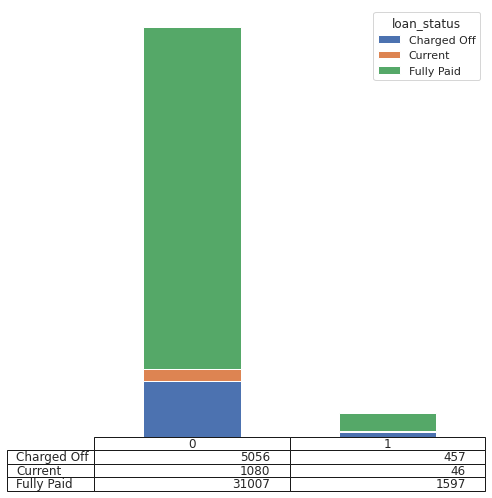

In [126]:
df['pub_rec_exists']= df.pub_rec.apply(lambda x: 1 if x>0 else 0)
bar_plot('pub_rec_exists' , 'loan_status',sizerow=7 , sizecolumn=7)

In [79]:
pd.crosstab([df.pub_rec_exists],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_exists,,,
0,0.136123,0.029077,0.834801
1,0.217619,0.021905,0.760476


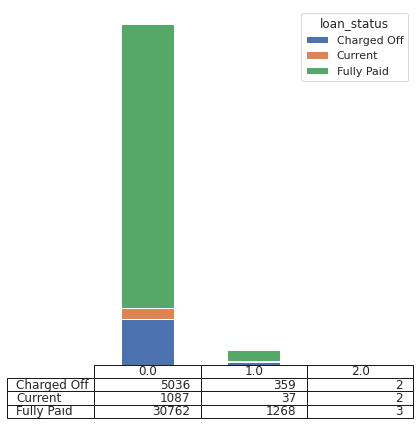

In [129]:
bar_plot('pub_rec_bankruptcies' , 'loan_status',sizerow=6 , sizecolumn=6)

In [130]:
pd.crosstab([df.pub_rec_bankruptcies ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
pub_rec_bankruptcies,,,
0.0,0.136532,0.029470,0.833998
1.0,0.215745,0.022236,0.762019
2.0,0.285714,0.285714,0.428571


In [80]:
pd.crosstab([df.pub_rec_bankruptcies ,df.pub_rec_exists ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                          Charged Off   Current  Fully Paid
pub_rec_bankruptcies pub_rec_exists                                   
0.0                  0                  0.135596  0.029609    0.834795
                     1                  0.220049  0.017115    0.762836
1.0                  1                  0.215745  0.022236    0.762019
2.0                  1                  0.285714  0.285714    0.428571

In [81]:
pd.crosstab([df.pub_rec_bankruptcies ,df.pub_rec_exists ,df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                       Charged Off  ...  Fully Paid
pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
0.0                  0              <0.09            0.059135  ...    0.936500
                                    <.12             0.111849  ...    0.863846
                                    <.15             0.149828  ...    0.817384
                                    <.25             0.226867  ...    0.714381
                     1              <0.09            0.095238  ...    0.904762
                                    <.12             0.148148  ...    0.851852
                                    <.15             0.246377  ...    0.739130
                                    <.25             0.248521  ...    0.721893
1.0                  1              <0.09            0.082090  ...    0.917910
                                    <.12             0.132388  ...    0.865248
                                    <.15             0.193050  ...    0.797297
                                    <.25             0.325976  ...    0.621392
2.0                  1              <.12             1.000000  ...    0.000000
                                    <.15             0.000000  ...    1.000000
                                    <.25             0.200000  ...    0.400000

[15 rows x 3 columns]

The chances of loan charge off is higher if banrupsies are present , even where no bankrupsy , any public record will increase chances of loan getting wrtten off

In [148]:
df.total_rec_late_fee.describe()

count    39243.000000
mean         1.365354
std          7.294391
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        180.200000
Name: total_rec_late_fee, dtype: float64

In [149]:
df['late_fee_status'] = df.total_rec_late_fee.apply(lambda c : 'Yes' if c>1 else 'No')

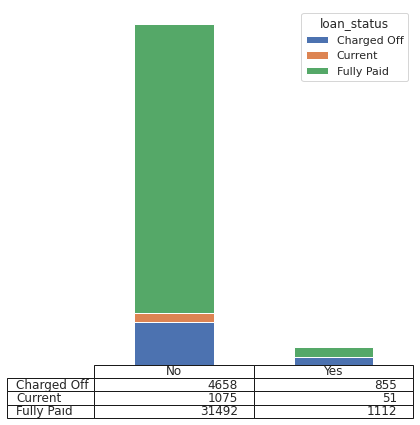

In [150]:
bar_plot('late_fee_status' , 'loan_status',sizerow=6 , sizecolumn=6)

In [151]:
pd.crosstab([df.late_fee_status ],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
late_fee_status,,,
No,0.125131,0.028878,0.845991
Yes,0.423687,0.025273,0.551041


In [152]:
pd.crosstab([df.late_fee_status,df.pub_rec_bankruptcies ,df.pub_rec_exists ,df.interest_bin],df.loan_status,values=df.loan_amnt,aggfunc='count',normalize= 'index')

loan_status                                                       Charged Off  ...  Fully Paid
late_fee_status pub_rec_bankruptcies pub_rec_exists interest_bin               ...            
No              0.0                  0              <0.09            0.051976  ...    0.943657
                                                    <.12             0.101689  ...    0.873446
                                                    <.15             0.132971  ...    0.833195
                                                    <.25             0.204378  ...    0.736123
                                     1              <0.09            0.095238  ...    0.904762
                                                    <.12             0.142857  ...    0.857143
                                                    <.15             0.223077  ...    0.761538
                                                    <.25             0.232258  ...    0.735484
                1.0                  1              <0.09            0.076336  ...    0.923664
                                                    <.12             0.120988  ...    0.876543
                                                    <.15             0.180894  ...    0.808943
                                                    <.25             0.313406  ...    0.634058
                2.0                  1              <.12             1.000000  ...    0.000000
                                                    <.15             0.000000  ...    1.000000
                                                    <.25             0.250000  ...    0.250000
Yes             0.0                  0              <0.09            0.347639  ...    0.648069
                                                    <.12             0.351801  ...    0.637119
                                                    <.15             0.411765  ...    0.571691
                                                    <.25             0.492154  ...    0.457917
                                     1              <.12             0.250000  ...    0.750000
                                                    <.15             0.625000  ...    0.375000
                                                    <.25             0.428571  ...    0.571429
                1.0                  1              <0.09            0.333333  ...    0.666667
                                                    <.12             0.388889  ...    0.611111
                                                    <.15             0.423077  ...    0.576923
                                                    <.25             0.513514  ...    0.432432
                2.0                  1              <.25             0.000000  ...    1.000000

[27 rows x 3 columns]